In [1]:
#! this code was run on kaggle, because kaggle offers 30 hrs of GPU usage per week.

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Preprocessing Stage
**the below cells does the following:**
- loading the dataset
- creating the data loaders
- converting the images into `Lab` workspace

**dataset name:**
`ImageNet (7GB)`

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imsave
from PIL import Image

def load_image_dataset(folder_path, transform):
    """
    Load all images from a folder into a PyTorch dataset.
    """
    images = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(file_path).convert('RGB')
            img = transform(img)
            images.append(img)
        except Exception as e:
            print(f"Error loading image {file_path}: {e}")
    return torch.stack(images)

# Paths for training and validation folders
train_folder = "/kaggle/input/imagenet/imagenet/train"
val_folder = "/kaggle/input/imagenet/imagenet/val"

# Preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),  # Convert to [0, 1] range
    #note that flipping and rotating images was not necessary because the dataset is huge
])

# Load datasets
train_dataset = load_image_dataset(train_folder, transform)
val_dataset = load_image_dataset(val_folder, transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)


### Convert to `Lab` workspace

In [3]:
def preprocess_lab(batch):
    X = [] # input (lightness channel)
    Y = [] # target (AB channels)
    for img in batch:
        img = img.permute(1, 2, 0).cpu().numpy()  # Convert to HWC after transferring to CPU
        lab = rgb2lab(img)
        X.append(lab[:, :, 0])          # Lightness channel
        Y.append(lab[:, :, 1:] / 128)  # AB channels scaled to [-1, 1]
    X = np.array(X)
    Y = np.array(Y)
    X = X[:, None, :, :]  # Add channel dimension to L channel
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)



### Model Stage 


### Use `VGG-16` as encoder.

In [4]:
# VGG16 encoder (pretrained on ImageNet)
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        vgg = models.vgg16(pretrained=True)
        self.features = vgg.features[:23]  # Use up to the last convolutional layer
        for param in self.features.parameters():
            param.requires_grad = False  # Freeze weights

    def forward(self, x):
        return self.features(x)


### Using a `Vanilla CNN` as a decoder

### What a decoder does:
**keeps upsampling the image till the desired size is achieved, in this case we want the final output to be `512x512`**

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 64x64
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # 128x128 (stopping here gives an error)
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1), # 256,256
            nn.ReLU(),
            nn.Conv2d(32, 2, kernel_size=3, padding=1), # 512,512
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        return nn.functional.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False) #convert the size to (128,128) 


### Combining both models

In [6]:

class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        features = self.encoder(x)
        return self.decoder(features)

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #cuda because on kaggle
model = ColorizationModel().to(device)
criterion = nn.MSELoss() #best criterion so far
optimizer = optim.Adam(model.decoder.parameters(), lr=0.0002)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 236MB/s]


### Training Loop

In [7]:

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images in train_loader:
        images = images.to(device)
        X, Y = preprocess_lab(images)
        X, Y = X.to(device), Y.permute(0, 3, 1, 2).to(device)  # Reshape Y to (N, 2, H, W)

        X = X.repeat(1, 3, 1, 1)  # Repeat the single L channel to create a 3-channel input

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss / len(train_loader):.4f}")

Epoch [1/30], Loss: 0.0145
Epoch [2/30], Loss: 0.0129
Epoch [3/30], Loss: 0.0128
Epoch [4/30], Loss: 0.0126
Epoch [5/30], Loss: 0.0126
Epoch [6/30], Loss: 0.0125
Epoch [7/30], Loss: 0.0124
Epoch [8/30], Loss: 0.0123
Epoch [9/30], Loss: 0.0122
Epoch [10/30], Loss: 0.0121
Epoch [11/30], Loss: 0.0120
Epoch [12/30], Loss: 0.0119
Epoch [13/30], Loss: 0.0117
Epoch [14/30], Loss: 0.0116
Epoch [15/30], Loss: 0.0114
Epoch [16/30], Loss: 0.0112
Epoch [17/30], Loss: 0.0110
Epoch [18/30], Loss: 0.0108
Epoch [19/30], Loss: 0.0106
Epoch [20/30], Loss: 0.0104
Epoch [21/30], Loss: 0.0102
Epoch [22/30], Loss: 0.0100
Epoch [23/30], Loss: 0.0098
Epoch [24/30], Loss: 0.0096
Epoch [25/30], Loss: 0.0095
Epoch [26/30], Loss: 0.0093
Epoch [27/30], Loss: 0.0092
Epoch [28/30], Loss: 0.0090
Epoch [29/30], Loss: 0.0089
Epoch [30/30], Loss: 0.0088


# Save the model for later use

In [8]:
# Save model
torch.save(model.state_dict(), "colorization_model0.pt")

### Testing the results

/tmp/ipykernel_23/1953735099.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


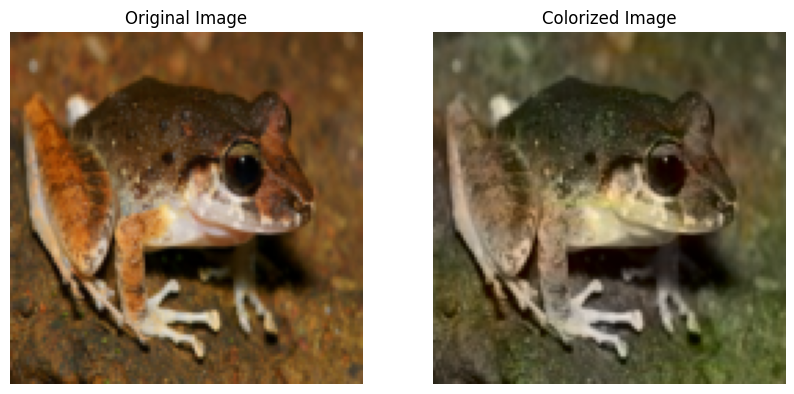

In [9]:
import matplotlib.pyplot as plt
def test_and_visualize(image, model_path):
    model = ColorizationModel().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Preprocess image
    img = image.to(device)
    L = rgb2lab(img.permute(1, 2, 0).cpu().numpy())[:, :, 0]
    L = torch.tensor(L).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)

    # Repeat L channel to create 3-channel input for the encoder
    L_pseudo_rgb = L.repeat(1, 3, 1, 1)  # Shape (1, 3, 128, 128)

    with torch.no_grad():
        ab = model(L_pseudo_rgb).cpu().numpy()[0].transpose(1, 2, 0) * 128

    # Combine L and AB channels
    lab = np.zeros((128, 128, 3))
    lab[:, :, 0] = L.squeeze().cpu().numpy()
    lab[:, :, 1:] = ab
    colorized = lab2rgb(lab)


    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img.permute(1, 2, 0).cpu().numpy())
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(colorized)
    ax[1].set_title("Colorized Image")
    ax[1].axis("off")

    plt.show()


sample_image = train_dataset[0]
test_and_visualize(sample_image, "colorization_model0.pt")


_post processing will give better results!_